# Feature and hyperparameter selection together

Typically, when using genetic search algorithms, I see either feature selection or hyperparameter search 
for predictive models. In the code provided I have implemented everything together.
The following libraries are required: **sklearn, matplotlib, seaborn, numpy, deap**  also need 
the **deap_gen_model_feat.py** file from this repository:

https://github.com/quant12345/mlgFinancialMarkets


In [9]:
# Let's define a coefficient for dividing the data into training and test sets.
split = 0.7# 70% train 30% test

# use directory path if needed
#import os
#os.chdir('/your path')

If you have your own dataset with labels for classification, then skip the following lines up to the dictionary lines with parameters.
I will form a dataset from stock quotes.

In [10]:
import pandas as pd

df = pd.read_csv('MSFT.csv', header=0)

print(df.head())

         Date      Close       High        Low       Open    Volume
0  2007-09-26  21.194248  21.445706  21.179879  21.323569  60337000
1  2007-09-27  21.187059  21.352302  21.151138  21.337934  43407100
2  2007-09-28  21.165504  21.330749  21.000262  21.187058  45819100
3  2007-10-01  21.388231  21.402601  21.129589  21.165511  43875100
4  2007-10-02  21.337938  21.445705  21.244539  21.337938  33700900


In [11]:
# Let's check if there are lines with nan
print(df[df.isna().any(axis=1)])

Empty DataFrame
Columns: [Date, Close, High, Low, Open, Volume]
Index: []


In [12]:
import deap_gen_model_feat as dgm
import numpy as np

hist = 10

returns = df['Close'].pct_change() * 100
returns5 = df['Close'].pct_change(5) * 100
returns15 = df['Close'].pct_change(15) * 100
indicator = [returns, returns5, returns15]

# form a dataset, each data type is shifted from 1 to hist
# as a result, we get each data type with the size of hist
dataset = dgm.preparing_dataset(indicator, hist)

# set dataset to dataframe
col = np.arange(dataset.shape[1])
df.loc[:, col] = dataset

# Let's make sure that the nan values are only at the beginning.
print(df[df.isna().any(axis=1)])

          Date      Close       High        Low       Open     Volume  \
0   2007-09-26  21.194248  21.445706  21.179879  21.323569   60337000   
1   2007-09-27  21.187059  21.352302  21.151138  21.337934   43407100   
2   2007-09-28  21.165504  21.330749  21.000262  21.187058   45819100   
3   2007-10-01  21.388231  21.402601  21.129589  21.165511   43875100   
4   2007-10-02  21.337938  21.445705  21.244539  21.337938   33700900   
5   2007-10-03  21.158325  21.445705  21.043373  21.345121   37633900   
6   2007-10-04  21.345119  21.388227  21.151139  21.237352   37868000   
7   2007-10-05  21.438526  21.546293  21.359496  21.474448   45012300   
8   2007-10-08  21.438526  21.445711  21.266098  21.309205   30265400   
9   2007-10-09  21.625317  21.833666  21.553471  21.575025   63603100   
10  2007-10-10  21.718714  21.819298  21.575025  21.582209   32251500   
11  2007-10-11  21.488811  22.006094  21.402598  21.769006   50788400   
12  2007-10-12  21.675610  21.840853  21.517551  21

In [13]:
# remove lines with nan
df = df.dropna().reset_index()

slice_split = int(len(df) * split)

# standardize the data by passing the array values
# obtained from the dataframe
dataset = dgm.features_standardized(df[col].values, slice_split)

# Labels for classification
y_labels = np.where(df['Close'] > df['Open'], 0, 1)

Now that the dataset and labels are ready, we can run the algorithm to find the 
best hyperparameters with simultaneous feature selection.

gen	nevals	max   	avg       
0  	450   	0.5589	0.00592264
1  	411   	0.5589	0.0132024 
2  	393   	0.5589	0.0169563 
3  	388   	0.56488	0.0267383 
4  	404   	0.56488	0.034119  
5  	412   	0.56488	0.0487972 
6  	408   	0.56589	0.0550284 
7  	417   	0.56694	0.0794762 
8  	413   	0.56694	0.0964316 
9  	406   	0.56694	0.12304   
10 	421   	0.56694	0.165959  
11 	395   	0.57097	0.185335  
12 	400   	0.57097	0.21368   
13 	413   	0.57097	0.278983  
14 	420   	0.57097	0.345185  
15 	400   	0.57097	0.357377  
16 	414   	0.57097	0.354012  
17 	399   	0.57097	0.389382  
18 	395   	0.57097	0.404549  
19 	408   	0.57097	0.415224  
20 	410   	0.57097	0.423719  
21 	405   	0.57097	0.405513  
22 	397   	0.57391	0.432663  
23 	399   	0.57391	0.425586  
24 	402   	0.57391	0.420822  
25 	413   	0.57391	0.440641  
26 	421   	0.57391	0.444383  
27 	406   	0.57391	0.466543  
28 	407   	0.57391	0.463436  
29 	402   	0.57391	0.455563  
30 	411   	0.57391	0.456391  
31 	395   	0.57391	0.477787  
32 	391   	0.5

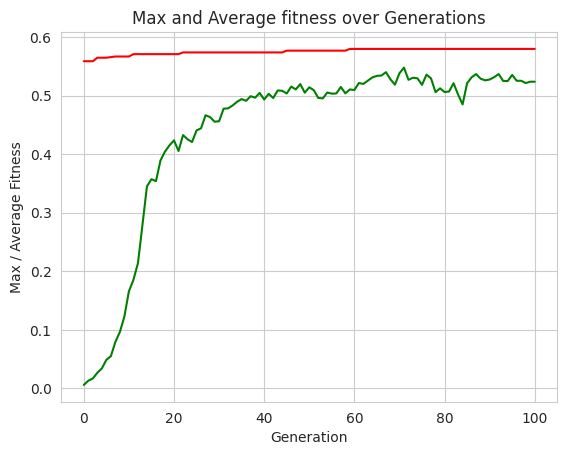

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score as metric


parameters_model = {
    'max_depth': [2, 4],
    'n_estimators': [5, 100],
    'learning_rate': [0.01, 0.9]
}

parameters = {
    'model': GradientBoostingClassifier,
    'metric': metric,
    'parameters' : parameters_model
}


'''
percent_label, metric_more, tolerance - used in class: Classifier.

percent_label -  percentage of predicted class 0 labels in the
test sample from the total number. Default value = 0.16.

metric_more - the resulting metric must be >= this number. Default value = 0.54.

tolerance - the absolute difference between train and test 
metrics should not exceed this number. Default value = 0.02.

print_rows - print result rows that passed the conditions
Default value = True.

Setting the model's string parameters is done directly
rows 113:115 clf = self.parameters_class['model'](
            **dict_parameters, max_features="sqrt", random_state=0
        )

Constants - population_size, probability_crossover, probability_mutation, 
generations_size, hall_of_fame_size, tournament_size: 
they are adjusted manually in the initial lines of the deap_gen_model_feat file.py
(this is very important and depends on the number of features)
'''

# Checking for 'FitnessMax' and 'Individual' is needed to run jupyter 
# notebook, but is not required when running the code directly.
from deap import creator

if "FitnessMax" in creator.__dict__:
    del creator.FitnessMax

if "Individual" in creator.__dict__:
    del creator.Individual

dgm.run(dataset, y_labels, parameters, slice_split, percent_label=0.16, print_rows=False)